<a href="https://colab.research.google.com/github/ka-tya/Udacity-_capstone/blob/master/UCI_ML_Drug_Review_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Capstone Project

In [0]:
#import libraries
import numpy as np
import pandas as pd
#for NLP:
import spacy
#import en_core_web_sm
nlp = spacy.load('en_core_web_sm') #vector, pos_tag
from spacy.lang.en import English,stop_words # Word tokenization #lemma
from spacy import displacy #word viz
import string
# #for the Pipiline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel 
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from gensim.models import Word2Vec

from matplotlib import pyplot as plt # viz
%matplotlib inline

#to display entire text 
pd.set_option('display.max_colwidth', None)

Using TensorFlow backend.


### Exploratory Data Review
1. Read in the data sets
2. What are the columns, dimentions, missing data
3. why they were pre-set into test & train: are there any major differences

In [0]:

# #COLAB VERSION
# #!pip install PyDrive

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# #https://drive.google.com/file/d/10Wj8r6jl6ELZQ-4mF-Yd0wesHR9Rs5qR/view?usp=sharing
# #https://drive.google.com/file/d/19GadXd0G-YNKwVlFqjHQZQKfTi0qbYvZ/view?usp=sharing

In [0]:
# downloaded = drive.CreateFile({'id':"10Wj8r6jl6ELZQ-4mF-Yd0wesHR9Rs5qR"})   # replace the id with id of file you want to access
# downloaded.GetContentFile('drugsComTest_raw.tsv')        # replace the file name with your file

# downloaded2 = drive.CreateFile({'id':"19GadXd0G-YNKwVlFqjHQZQKfTi0qbYvZ"})
# downloaded2.GetContentFile('drugsComTrain_raw.tsv')

In [0]:
#1
#Read in the data
#convert date into correct format

#JUPYTER VERSION
train = pd.read_csv('drugsComTrain_raw.tsv', sep='\t',parse_dates = ['date']) 
test = pd.read_csv('drugsComTest_raw.tsv', sep='\t',parse_dates = ['date'])
#appears to have an unnamed index column that needs to be dropped
del test['Unnamed: 0'], train['Unnamed: 0']

In [0]:
#2

train.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9.0,2012-05-20,27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective.""",8.0,2010-04-27,192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.""",5.0,2009-12-14,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch""",8.0,2015-11-03,10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around. I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account. I had none of those before Suboxone and spent years abusing oxycontin. My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction. All that is history. If you&#039;re ready to stop, there&#039;s a good chance that suboxone will put you on the path of great life again. I have found the side-effects to be minimal compared to oxycontin. I&#039;m actually sleeping better. Slight constipation is about it for me. It truly is amazing. The cost pales in comparison to what I spent on oxycontin.""",9.0,2016-11-27,37


In [0]:
#shape of train data, columns
print(train.shape)
train.columns

(161297, 6)


Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'], dtype='object')

In [0]:
#shape of test data, columns
print(test.shape)
test.columns

(53766, 6)


Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'], dtype='object')

In [0]:
#missing values
train.isnull().sum()/train.shape[0],test.isnull().sum()/test.shape[0]

# only 0.5% of the data in both sets. 
# if the drug is available in the data set - the condition can be extrapolated
# else with such a small number - it can be exluded

(drugName       0.000000
 condition      0.005574
 review         0.000000
 rating         0.000000
 date           0.000000
 usefulCount    0.000000
 dtype: float64, drugName       0.000000
 condition      0.005487
 review         0.000000
 rating         0.000000
 date           0.000000
 usefulCount    0.000000
 dtype: float64)

In [0]:
#what drugs are missing conditions are missing and how to resolve it 
drugNoCond = train[train.condition.isnull()].drugName.unique()
print('Drugs with no condition description: ',len(drugNoCond))
print('Drugs that have no other records with conditions')
len(set(train[train.condition.isnull()].drugName) - set(train.drugName))

Drugs with no condition description:  258
Drugs that have no other records with conditions


0

In [0]:
#are there drugs with multiple conditions?
train.groupby('drugName').condition.nunique().mean()

2.470896391152503

In [0]:
#create a unique drug - condition list
drugCond = train[['drugName','condition']].drop_duplicates()
#check how many conditions have the drugs with missing ones
drugCond[drugCond.drugName.isin(drugNoCond)].groupby('drugName').condition.count().mean()

#cannot replace missing condition

5.0271317829457365

In [0]:
#3
#what drugs are available in each set
print('Drugs in the train set: {}, test set: {}'.format(train.drugName.nunique(),test.drugName.nunique()))
#how many reviews per drug on average
print('average reviews per drug')
print(round(train.groupby('drugName').review.count().mean(),2),',',round(test.groupby('drugName').review.count().mean(),2))

#how many intersect in both sets
print('Drugs in train not in test: ',len(list(set(train.drugName.unique())-set(test.drugName.unique()))))
print('It is ',len(list(set(train.drugName.unique())-set(test.drugName.unique())))/len(train.drugName.unique()),'% of train')
print('Drugs in test not in train: ',len(list(set(test.drugName.unique())-set(train.drugName.unique()))))
print('It is ',len(list(set(test.drugName.unique())-set(train.drugName.unique())))/len(test.drugName.unique()),'% of test')


Drugs in the train set: 3436, test set: 2637
average reviews per drug
46.94 , 20.39
Drugs in train not in test:  1034
It is  0.3009313154831199 % of train
Drugs in test not in train:  235
It is  0.08911642017444066 % of test


In [0]:
#are there any time differences
print('train date range: ', train.date.min(), train.date.max())
print('test date range: ', test.date.min(), test.date.max())
#same

train date range:  2008-02-24 00:00:00 2017-12-12 00:00:00
test date range:  2008-02-25 00:00:00 2017-12-12 00:00:00


In [0]:
#that is a weird data split
#join it back together
#delete the rows with missing condition
full_set = pd.concat([train,test])
full_set = full_set[~full_set.condition.isnull()]
full_set.shape

(213869, 6)

In [0]:
#how many drugs per set
print('Total drugs in the set ',full_set.drugName.nunique())
print('Total conditions in the set ',full_set.condition.nunique())

Total drugs in the set  3667
Total conditions in the set  916


In [0]:
#what is the drug count per condition?
print('Average drugs per condition ',full_set.groupby('condition').drugName.nunique().mean())
full_set.groupby('condition').drugName.nunique().sort_values(ascending = False).head(20)

Average drugs per condition  10.312227074235809


condition
Not Listed / Othe                             253
Pain                                          219
Birth Control                                 181
High Blood Pressure                           146
Acne                                          127
Depression                                    115
Rheumatoid Arthritis                          107
Diabetes, Type 2                               97
Allergic Rhinitis                              95
Insomnia                                       85
Osteoarthritis                                 84
Bipolar Disorde                                82
Anxiety                                        81
Abnormal Uterine Bleeding                      77
Endometriosis                                  64
3</span> users found this comment helpful.     62
Psoriasis                                      61
Migraine                                       60
ADHD                                           58
4</span> users found this comment helpfu

In [0]:
#any condition/drug with special characters?
#exclude space and fw slash
#has ')' and '<' #173 rows
print('Percent of error text in condition: ', full_set[(~full_set.condition.str.isalnum())&(~full_set.condition.str.contains('/| |-|,'))].\
                                              shape[0]/full_set.shape[0])
print('Percent of "NOT LISTED" condition: ', full_set[full_set.condition=="Not Listed / Othe"].shape[0]/full_set.shape[0])
print('Percent of error text in drug: ', full_set[(~full_set.drugName.str.isalnum())&(~full_set.drugName.str.contains('/| |-|,'))].\
                                              shape[0]/full_set.shape[0])

Percent of error text in condition:  0.0008089063866198467
Percent of "NOT LISTED" condition:  0.002768049600456354
Percent of error text in drug:  0.0


In [0]:
#All the issues will affect further analysis and cannot be fixed 
#they make up to 2% of the data 
# delete rows

#if condition has special char like ) or <
#if condition in "NOT LISTED"

print(full_set.shape[0])
full_set = full_set[~full_set.condition.str.contains('\<|\?|\)|\(')]
print(full_set.shape[0])
full_set = full_set[full_set.condition!="Not Listed / Othe"]
print(full_set.shape[0])
print('final set to initial data is ',full_set.shape[0]/(train.shape[0]+test.shape[0]))

213869
212347
211755
final set to initial data is  0.9846184606371157


In [0]:
#create couple of useful columns for visualizations and further analysis
full_set.loc[full_set.rating<4,'rating_group']  = '-1'
full_set.loc[full_set.rating.between(4,8),'rating_group']  = '0'
full_set.loc[full_set.rating>=8,'rating_group']  = '1'

full_set['year'] = full_set['date'].dt.year

#### Visual Exploratory Data Analysis*

*full set

In [0]:
#Top 10 reviewed & rated drugs
top_drugs = full_set.groupby('drugName').agg({'rating':['count','mean']}).reset_index()
top_drugs.columns = ['drugName','rating_count','rating_mean']
top_reviewed = top_drugs.sort_values(by = 'rating_count').tail(10)
top_rated = top_drugs[top_drugs.rating_count>50].sort_values(by = ['rating_mean']).tail(10)

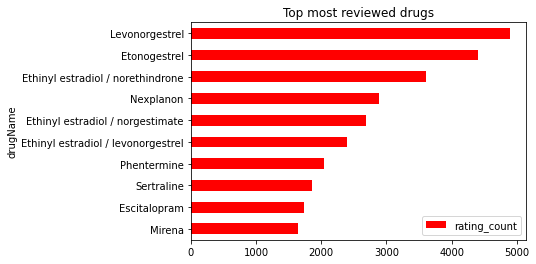

In [0]:
top_reviewed.plot(kind='barh',y='rating_count',x='drugName',color='r',\
                 title = 'Top most reviewed drugs');

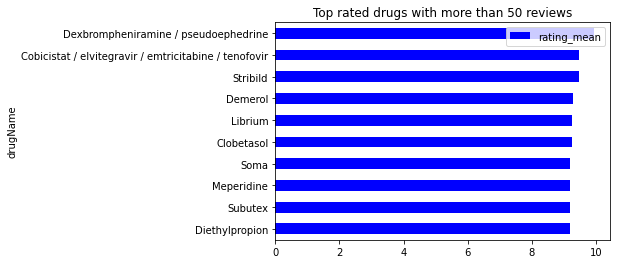

In [0]:
top_rated.plot(kind='barh',y='rating_mean',x='drugName',color='b',\
              title = 'Top rated drugs with more than 50 reviews');

In [0]:
#Top 10 reviewed & rated conditions
top_cond = full_set.groupby('condition').agg({'rating':['count','mean']}).reset_index()
top_cond.columns = ['condition','rating_count','rating_mean']
top_reviewed_cond = top_cond.sort_values(by = 'rating_count').tail(10)
top_rated_cond = top_cond[top_cond.rating_count>50].sort_values(by = ['rating_mean']).tail(10)

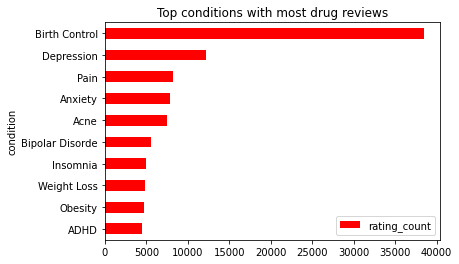

In [0]:
top_reviewed_cond.plot(kind='barh',y='rating_count',x='condition',color='r',\
                 title = 'Top conditions with most drug reviews');

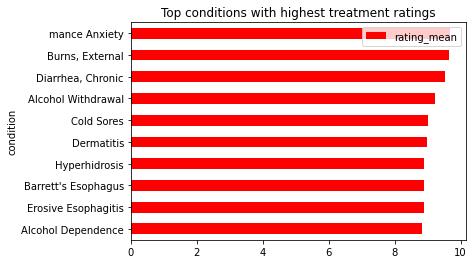

In [0]:
top_rated_cond.plot(kind='barh',y='rating_mean',x='condition',color='r',\
                 title = 'Top conditions with highest treatment ratings');

In [0]:
#do people tend to leave more negative or positive reviews
full_set.groupby('rating_group').review.count()/full_set.shape[0]

rating_group
-1    0.218295
0     0.178215
1     0.603490
Name: review, dtype: float64

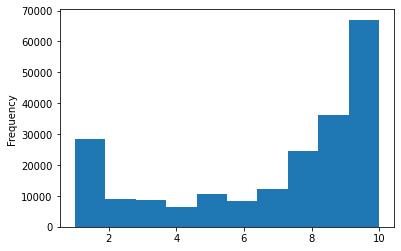

In [0]:
#rating distro
full_set.rating.plot(kind = 'hist');

In [0]:
# #correlation btween usefulness and rating
# plt.scatter(full_set['rating'], full_set['usefulCount'], alpha=0.5, c = full_set['rating_group']);
# plt.xlabel("rating");
# plt.ylabel("usefulness");

#positive reviews have higher chanse to be considered useful

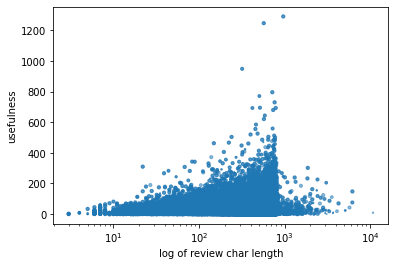

In [0]:
#correlation btween usefulness and review length
x = full_set['review'].str.len()
y = full_set['usefulCount']
size = full_set['rating']
plt.scatter(x,y,s = size , alpha=0.5); #, c = full_set['rating_group']
plt.xlabel("log of review char length");
plt.ylabel("usefulness");
plt.xscale('log');
#seems like too long or too short reviews are less useful
#reviews between 100 - 1000 char are most useful - or at least most readable

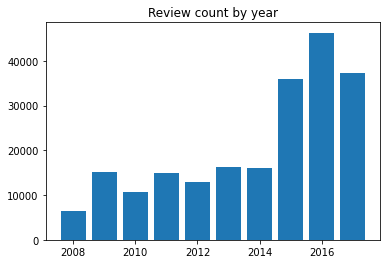

In [0]:
# #reviews by year
counts = full_set.groupby('year').review.count().reset_index()
plt.bar(x = counts['year'], height = counts['review']);
plt.title('Review count by year');

### Sentiment analysis

#### Predict rating based on review

#### Built the model for sentiment analysis
####  Evaluating the Model
Check few models:
1. One vs Rest
2. SVC
3. Simple NN



After the model is trained test data through the pipeline to come up with predictions. 

<!-- Check performance of the model using such metrics as model’s accuracy, precision, and recall.

* *Accuracy* refers to the percentage of the total predictions our model makes that are completely correct.
* *Precision* describes the ratio of true positives to true positives plus false positives in our predictions.
* *Recall* describes the ratio of true positives to true positives plus false negatives in our predictions. -->

In [0]:
#Load stop words
stopwords = stop_words.STOP_WORDS
# Create our list of punctuation marks
punctuations = string.punctuation
# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [0]:
#since we are doing sentiment analysis on review positivity , it makes sence to keep negative stop words
stopwords = stopwords - set(["n't",'none','not', 'nothing','n‘t', 'n’t', 'no'])

In [0]:
full_set.review.head(3)
# looks like ' is replaced by &#039; - need to clean

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          "It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"
1                  "My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cra

In [0]:
#create custom tokennizer
def spacy_tokennizer(sent):
    #removing the &#039; combo:
    sent = sent.replace('&#039;',"'").replace('&quot;', '').replace('&amp;', '')
    #create token object
    parsed = nlp(sent)
    token_list = []
    for word in parsed:
        # Removing stop words
        if (word.lemma_ not in stopwords) and (word.lemma_ not in punctuations) and (word.pos_ !='PRON'):
            # Lemmatizing each token and converting each token into lowercase
            w=word.lemma_.lower().strip()
            token_list.append(w)
            
    # return preprocessed list of tokens
    return token_list

In [0]:
#split data into test and train
X = full_set['review']
y = full_set['rating_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 33)

In [0]:
#1 One vs Rest
pipeline= Pipeline([
            ('vectorizer', CountVectorizer(tokenizer=spacy_tokennizer, ngram_range=(3,5))),
            ('tfidf', TfidfTransformer()),
            ('classifier', OneVsRestClassifier(LogisticRegression(solver = 'liblinear'))),
        ])

In [0]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(3, 5), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spac...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(C=1.0,
                                                                  class_weight=None,
               

In [0]:
y_pred  = pipeline.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.80      0.69      0.74     14042
           0       0.74      0.26      0.38     11249
           1       0.78      0.97      0.86     38236

    accuracy                           0.78     63527
   macro avg       0.77      0.64      0.66     63527
weighted avg       0.78      0.78      0.75     63527



In [0]:
#2 SVC
# param_grid = {'C':np.arange(0.01,100,10)}
# clf = GridSearchCV(
#     svm.LinearSVC((), param_grid,cv =5)

pipeline_svm = Pipeline([
            ('vectorizer', CountVectorizer(tokenizer=spacy_tokennizer, ngram_range=(1,4))),
            ('tfidf', TfidfTransformer()),
            ('classifier', svm.LinearSVC()),
        ])
#

In [0]:
pipeline_svm.fit(X_train,y_train)
#print("Best estimator found by grid search:")
#print(pipeline_svm.best_estimator_)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 4), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokennizer at 0x7f64f72416a8>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
  

In [0]:
y_pred_svm  = pipeline_svm.predict(X_test)
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

          -1       0.87      0.85      0.86     14042
           0       0.85      0.67      0.75     11249
           1       0.90      0.96      0.93     38236

    accuracy                           0.89     63527
   macro avg       0.87      0.83      0.85     63527
weighted avg       0.88      0.89      0.88     63527



In [0]:
#3 NN
#Instead of using pipeline, need to enumerate the input first
X_full = pd.concat([X_train,X_test])
tr_shape = X_train.shape[0]
print(X_train.shape[0])
print(X_full.shape[0])
y_full = pd.concat([y_train,y_test])

vectorizer = CountVectorizer(binary=True, stop_words=stopwords,
                             lowercase=True, max_features=5000)
X_onehot = vectorizer.fit_transform(X_full)
print(X_onehot.toarray())

names_list = vectorizer.get_feature_names()
names = [[i] for i in names_list]
names = Word2Vec(names, min_count=1)
print(len(list(names.wv.vocab)))
print(list(names.wv.vocab)[:5])

y_onehot= keras.utils.to_categorical(y_full,3)
print(y_onehot)

148228
211755


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
5000
['00', '000', '00am', '00pm', '01']
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [0]:
#check which position is which type of rating
print(y_full[-2:-1])
print(y_onehot[-2:-1])
print("---")
print(y_full[-1:])
print(y_onehot[-1:])
print("---")
print(y_full[-4:-3])
print(y_onehot[-4:-3])

59733    1
Name: rating_group, dtype: object
[[0. 1. 0.]]
---
42029    0
Name: rating_group, dtype: object
[[1. 0. 0.]]
---
93534    -1
Name: rating_group, dtype: object
[[0. 0. 1.]]


In [0]:

# # Separate data and one-hot encode the output
# # Note: We're also turning the data into numpy arrays, in order to train the model in Keras
X_train = X_onehot[:tr_shape]
X_test = X_onehot[tr_shape:]
y_train = y_onehot[:tr_shape]
y_test = y_onehot[tr_shape:]

features = np.array(X_train)
targets = np.array(y_train)
features_test = np.array(X_test)
targets_test = np.array(y_test)

model = Sequential()
model.add(Dense(64,  input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                320064    
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [0]:
# Training the model
model.fit(X_train, y_train, epochs=200, batch_size=5000, verbose=0)

score = model.evaluate(X_train, y_train, verbose=0)
print("TRAIN Accuracy: ", score[1])

 ## 6. Evaluating the model
 #This will give you the accuracy of the model, as evaluated on the testing set. Can you get something over 85%?

score = model.evaluate(X_test, y_test, verbose=0)
print("TEST Accuracy: ", score[1])

TRAIN Accuracy:  0.9988328814506531
TEST Accuracy:  0.8629243969917297


####  Evaluating the Model
After the model is trained test data through the pipeline to come up with predictions. Check performance of the model using such metrics as model’s accuracy, precision, and recall.

* *Accuracy* refers to the percentage of the total predictions our model makes that are completely correct.
* *Precision* describes the ratio of true positives to true positives plus false positives in our predictions.
* *Recall* describes the ratio of true positives to true positives plus false negatives in our predictions.

### Medicine Recommendation System
* The original idea was to find another dataset with medicine ingredient list and provide a personalised recommedation based on user previous history (alergies, side effects) or based on possible negative side effects of adding a new drug to existing prescriptions. However, I was not able to find a dataset that would provide enough information to implement this.
* This is a simple recommender system based on medicine rating and prevalance

The data has columns rating, usefulCount and date. I want to use all three to sort the drugs for recommendation. To create a list of drugs for each condion
    * a small coefficient is applied to the rating depending how old the review is to favor recent reviews
    * another coefficient is applied to the rating based on the usefulness to favor more useful reviews
    * the rating mean is calculated for each drug & condition



In [0]:
def simple_recommender_with_adj(c, n = 10,df = full_set):
    '''
    input:
    c - illness/disorder/condition
    n - number of requested drugs
    df - data set to work with
    
    output - recommended top n treatment drugs 
    '''
    alpha =  df.year/df.groupby('condition').year.transform('max') #adjustment for review age
    beta  =   (df.usefulCount/df.groupby('condition').usefulCount.transform('max')).fillna(0)
    
    df['rating_adj'] = (df.rating*alpha +beta)*10/(np.max(df.rating*alpha +beta)) #normalizing back to 10 point scale
    
    #filter for conditions with at least three drugs & at least 5 reviews
    cond = df.groupby('condition').drugName.count()
    rev =  df.groupby('drugName').review.count()
    rec_set = df[(df.condition.isin(cond[cond>2].index))&(df.drugName.isin(rev[rev>5].index))]
    

    rec_set = rec_set.groupby(['condition','drugName']).rating_adj.mean().reset_index().\
                sort_values(by = ['condition', 'rating_adj'], ascending = False)
    final = rec_set.loc[rec_set.condition ==c,['drugName','rating_adj']].drop_duplicates().reset_index()
    return final.drugName.head(n)


In [0]:
simple_recommender_with_adj('Acne',10)

0                          Aldactone
1                       Erythromycin
2                             Septra
3                           Doxy 100
4                            Bactrim
5                          Benzaclin
6                   Benzoyl peroxide
7                            Retin-A
8    Benzoyl peroxide / erythromycin
9                            Onexton
Name: drugName, dtype: object

In [0]:
def sentiment_recommender(c,d,r, df = full_set, vectorizer = vectorizer):
    '''
    input:
    c - illness/disorder/condition
    d - drug
    r - patient review
    n - number of requested drugs
    df - full set from earlier
    vectorizer - from the sentiment analysis
    
    output - recommended top n treatment drugs 
    '''
    # check a new review rating:
    #turn string into series
    r = pd.Series(r)
    new_one_hot = vectorizer.transform(r)
    #model.predict(new_one_hot)  # [neutral, positive, negative]
    pos = np.argmax(model.predict(new_one_hot))
    rec = simple_recommender_with_adj(c)
    #get drug index
    ind = rec.index[rec==d].to_numpy()[0] 
    if pos ==1:
      #positive review
      print('It is wonderful you are happy with your meds.')
      if ind >0:
        #exclude the current drug from the list
        print("Here are some other great meds to keep in mind")
      rec = rec[rec != d].head(3)
      
    else :
      #negative/ neutral review
      print("Looks like the medicine didn't satisfy your needs." )
      print("Here is what you can consider")

      #get current drug index and recomment only ones that are ranked higher
      #return top 5
      if ind >0:
        rec = rec[rec.index<ind].head(5)
      #if index == 0
      #recomend the next two
      else:
        rec = rec[rec != d].head(2)
    return rec.values

In [0]:
r = 'Not working'#'wonderful amazing works like a charm'
d = 'Bactrim'
c = 'Acne'

sentiment_recommender(c,d,r)

Looks like the medicine didn't satusfy your needs.
Here is what you can consider


array(['Aldactone', 'Erythromycin', 'Septra', 'Doxy 100'], dtype=object)

## Medicine similarity
What Meds are more similar to each other.
Can it be wrapped in to another recommender?


In [0]:
#there are total 3635 drugs - that is quite a lot. how many only have less than 10 reviews?
med_counts = full_set.groupby('drugName').review.nunique().\
                    sort_values(ascending = False).reset_index().rename(columns = {'review':'COUNTS'})

med_counts.shape[0] - med_counts[med_counts.COUNTS<=10].shape[0]

1485

In [0]:
# filter to more than 20 reviews per drug
# and for useful count >50
keep = (full_set.groupby('drugName').review.nunique()>20).reset_index()
keep =keep[keep.review == True].drugName.values

#combine all reviews by  count>20 per drug
all_revs =full_set[(full_set.drugName.isin(keep))&(full_set.usefulCount>50)]
drugs= all_revs['drugName'].unique()
print('drug ',drugs.shape[0])
reviews = all_revs.groupby(['drugName'])['review'].agg(lambda col: ''.join(col)).reset_index()
print('reviews ',reviews.shape[0])

drug  899
reviews  899


In [0]:
#Create a similarity matrix for drugs
def create_similarity_matrix( df = reviews):
      '''
    input:
    c - illness/disorder/condition
    d - drug
    n - number of requested drugs
    df - reviews df filtered by review count & useful count criteria
    
    output - recommended top n treatment drugs 
    '''

    #df = df[df.drugName == d]
    drugs = df.drugName.unique()
    vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,4))
    X = vectorizer.fit_transform(df['review'].tolist())
     
    similarity_matrix = pd.DataFrame(linear_kernel(X, X), index = drugs, columns =drugs)
    return similarity_matrix

In [0]:
def similarity_matrix_recommender(d,c,n=10,df = reviews, all_revs = all_revs):
    '''
    input:
    c - illness/disorder/condition
    d - drug
    n - number of requested drugs
    df - reviews df filtered by review count & useful count criteria from earlier
    all_revs - df where drug has a single row with all reviews combined together
    output - recommended top n treatment drugs 
    '''
    drug_matrix = create_similarity_matrix()[d].sort_values(ascending = False)
    #get top n closely matching drugs
    final = all_revs[(all_revs.drugName.isin(drug_matrix.index[1:n]))&(all_revs.condition==c)].groupby(['drugName','condition']).rating.mean()
    final = final.sort_values(ascending = False).reset_index()
    #final.drugName.values
    return final

In [0]:
d = 'Accutane'
c = 'Acne'
n = 10
similarity_matrix_recommender(d,c,n)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,drugName,condition,rating
0,Spironolactone,Acne,9.560000
1,Isotretinoin,Acne,9.432432
2,Minocycline,Acne,9.400000
3,Drospirenone / ethinyl estradiol,Acne,9.357143
4,Solodyn,Acne,9.333333
5,Yasmin,Acne,9.285714
6,Tretinoin,Acne,9.147059
7,Differin,Acne,8.933333
8,Adapalene,Acne,8.611111


In [220]:
d = None

d==None

True

In [0]:
#combine all together
def medicine_recommender(c, d = None, r= None, n = 3, df = full_set):
  '''
  input:
  c - condition patient is diagnosed with
  d - drug name, if currently using any
  r - patients review/ feedback

  output: top n drugs to try
  '''
  #case 1 - new diagnosis
  #use simple recommender
  if d==None:
    rec = simple_recommender_with_adj(c,n)

  #if patient has a history of drugs.
  #get drug review (d,r)
  #use sentiment recommender
  else:
    rec = sentiment_recommender(c,d,r)
  return rec

In [229]:
c = 'Acne'
d = 'Bactrim'
r = 'Slowly working. Terrible side effects'
medicine_recommender(c, d = d, r= r, n = n)

Looks like the medicine didn't satisfy your needs.
Here is what you can consider


array(['Aldactone', 'Erythromycin', 'Septra', 'Doxy 100'], dtype=object)